### 1: Load data and run infomap

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from infomap import Infomap
import networkx as nx
import numpy as np

# load csv
csv_path = "morrisonhighresedges_new.csv" 
df = pd.read_csv(csv_path)

# map node names to int
unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# build network with infomap
im = Infomap("--two-level --markov-time 0.3 --preferred-number-of-modules 5 --num-trials 150")

#--preferred-number-of-modules 5 

for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    im.add_link(u, v, weight)

im.run()

# id modules
modules = {node.node_id: node.module_id for node in im.nodes}
name_modules = {reverse_node_map[node_id]: mod for node_id, mod in modules.items()}

  Infomap v2.8.0 starts at 2025-07-06 23:38:17
  -> Input network: 
  -> No file output!
  -> Configuration: two-level
                    markov-time = 0.3
                    preferred-number-of-modules = 5
                    num-trials = 150
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'undirected'... 
  -> Using undirected links.
  => Sum node flow: 1.000000000, sum link flow: 1.000000000
Build internal network with 45 nodes and 155 links...
  -> Rescale link flow with global Markov time 0.300000000
  -> One-level codelength: 5.127745843

Trial 1/150 starting at 2025-07-06 23:38:17
Two-level compression: 21.88% 1.11% 
Partitioned to codelength 0.422046382 + 3.539489293 + 0.000000000 = 3.961535675 in 5 modules.

=> Trial 1/150 finished in 0.000394875s with codelength 3.961535675

Trial 2/150 starting at 2025-07-06 23:38:17
Two-level compression: 21.53% 1.03% 0.467766359% 0.077044758% 0.003347629% 

### 2: Obtain module robustness

In [9]:
import pandas as pd
import numpy as np
from infomap import Infomap
from collections import defaultdict

# === Load CSV and build node mapping ===
csv_path = "morrisonhighresedges_new.csv"
df = pd.read_csv(csv_path)

unique_nodes = pd.unique(df[['from', 'to']].values.ravel())
node_map = {name: i for i, name in enumerate(unique_nodes)}
reverse_node_map = {i: name for name, i in node_map.items()}

# === Build the original network links ===
links = []
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    weight = float(row["weight"])
    links.append((u, v, weight))

# === Run Infomap once to get proposed modules ===
im0 = Infomap("--two-level --markov-time 0.3 --preferred-number-of-modules 5 --num-trials 150 --silent")
for u, v, w in links:
    im0.add_link(u, v, w)
im0.run()

# Proposed modules as dict: module_id -> set of node_ids
proposed_modules = defaultdict(set)
for node in im0.nodes:
    proposed_modules[node.module_id].add(node.node_id)

# === Function to run Infomap and get modules (module_id -> set of node_ids) ===
def run_infomap(links):
    im = Infomap("--two-level --markov-time 0.3 --preferred-number-of-modules 5 --silent")
    for u, v, w in links:
        im.add_link(u, v, w)
    im.run()
    modules = defaultdict(set)
    for node in im.nodes:
        modules[node.module_id].add(node.node_id)
    return modules

# === Function to compute Jaccard similarity between two sets ===
def jaccard(set1, set2):
    inter = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return inter / union if union > 0 else 0

# === Number of bootstrap / runs ===
n_runs = 1000

# === Accumulate max similarity per proposed module across runs ===
similarity_sums = {mod_id: 0.0 for mod_id in proposed_modules.keys()}

for i in range(n_runs):
    modules_new = run_infomap(links)

    for p_mod_id, p_nodes in proposed_modules.items():
        max_sim = 0.0
        for new_mod_id, new_nodes in modules_new.items():
            sim = jaccard(p_nodes, new_nodes)
            if sim > max_sim:
                max_sim = sim
        similarity_sums[p_mod_id] += max_sim  # add max similarity for this run

# === Calculate average max similarity over runs ===
average_similarities = {mod_id: similarity_sums[mod_id] / n_runs for mod_id in similarity_sums.keys()}

# === Print results ===
print("Module ID : Average maximum Jaccard similarity over {} runs".format(n_runs))
for mod_id, avg_sim in average_similarities.items():
    print(f"Module {mod_id}: {avg_sim:.3f}")

Module ID : Average maximum Jaccard similarity over 1000 runs
Module 1: 0.538
Module 2: 0.385
Module 3: 0.357
Module 4: 0.400
Module 5: 0.583


### 3: Plot output

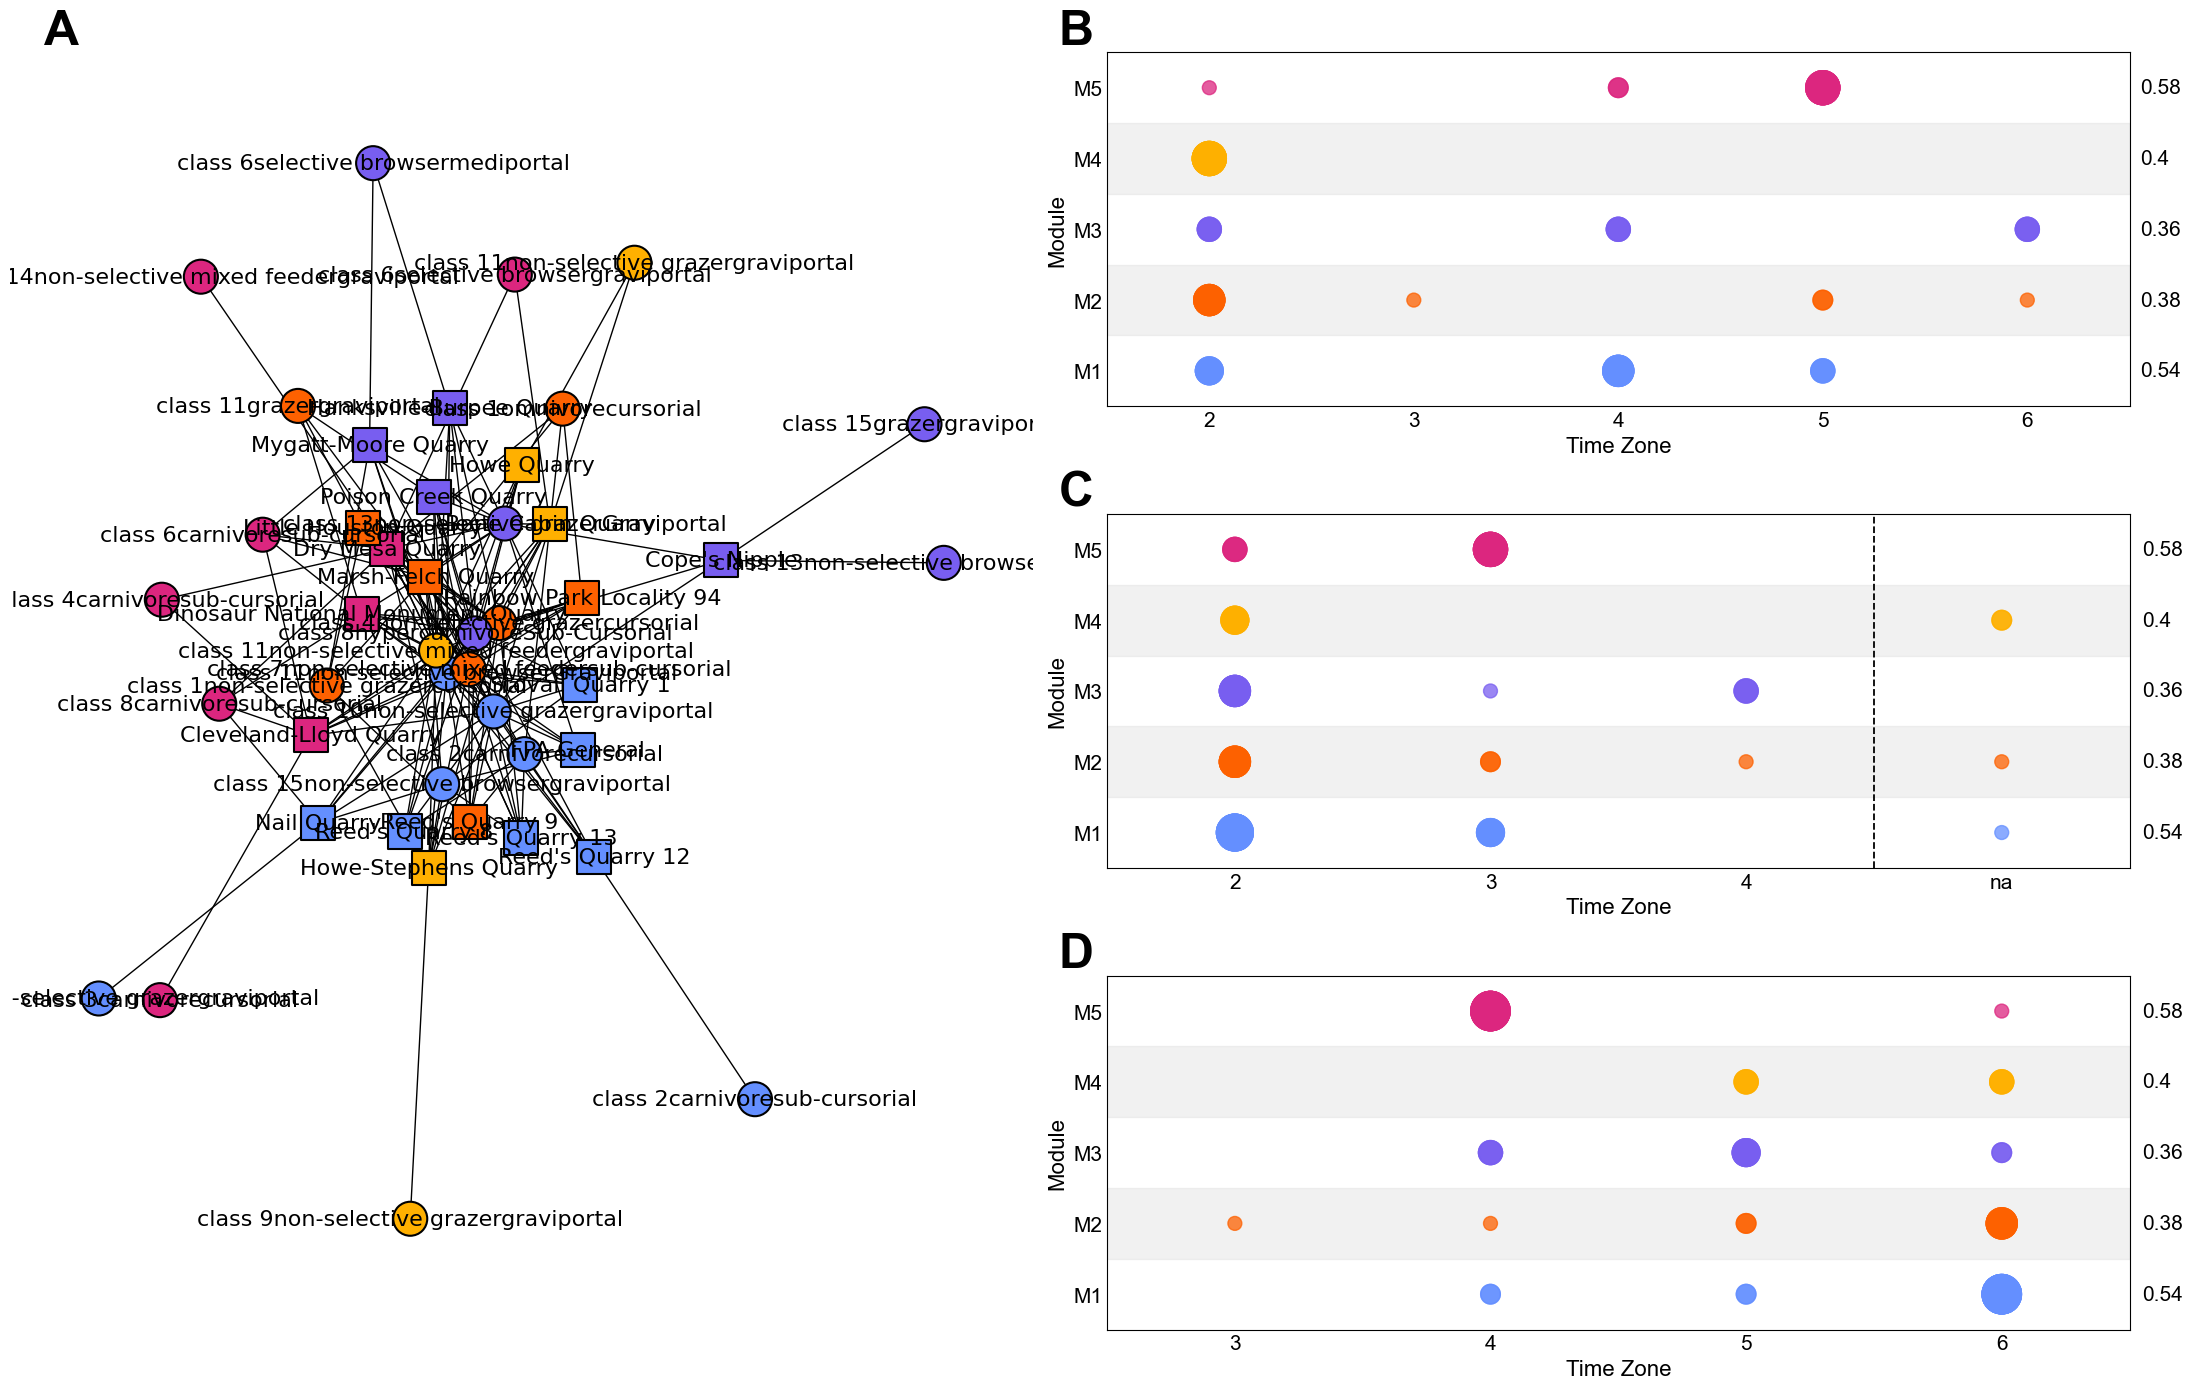

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

plt.rcParams['font.family'] = 'Arial'

# === Define custom hex colours ===
custom_colors = ['#648FFF', '#FE6100', '#785EF0', '#FFB000', '#DC267F', '#009E73', '#F0E442', '#0072B2']

# Build zone_maps for all time schemes
time_cols = ["time_foster", "time_turner", "time_maidment"]
zone_maps = {
    time_col: {zone: i + 1 for i, zone in enumerate(sorted(df[time_col].dropna().unique()))}
    for time_col in time_cols
}

# Make networkx graph
G = nx.Graph()
for _, row in df.iterrows():
    u = node_map[row["from"]]
    v = node_map[row["to"]]
    G.add_edge(u, v, weight=row["weight"])

nx.set_node_attributes(G, modules, "module")

# Map module IDs to custom colours
unique_modules = sorted(set(modules.values()))
module_color_map = {mod: custom_colors[i % len(custom_colors)] for i, mod in enumerate(unique_modules)}

# Prepare for plotting: 1 network plot + 3 stepped plots
fig = plt.figure(figsize=(22, 14))
gs = fig.add_gridspec(3, 2, width_ratios=[2, 2])
ax_net = fig.add_subplot(gs[:, 0])  # Network plot on the left
axes = [fig.add_subplot(gs[i, 1]) for i in range(3)]  # 3 vertical plots on the right

# ======= Network Plot =======
# Assign shapes 
node_shapes = {}
for _, row in df.iterrows():
    node_shapes[node_map[row["to"]]] = "circle"
    node_shapes[node_map[row["from"]]] = "square"

# Group nodes by shape
square_nodes = [n for n, shape in node_shapes.items() if shape == "square"]
circle_nodes = [n for n, shape in node_shapes.items() if shape == "circle"]

# Node positions
pos = nx.spring_layout(G, seed=42)

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, ax=ax_net)
nx.draw_networkx_nodes(G, pos, nodelist=square_nodes, node_shape='s', edgecolors='black',
                       node_color=[module_color_map.get(modules[n], "#cccccc") for n in square_nodes],
                       linewidths=1.5, node_size=600, ax=ax_net)
nx.draw_networkx_nodes(G, pos, nodelist=circle_nodes, node_shape='o', edgecolors='black',
                       node_color=[module_color_map.get(modules[n], "#cccccc") for n in circle_nodes],
                       linewidths=1.5, node_size=600, ax=ax_net)

# === Add node labels ===
reverse_node_map = {v: k for k, v in node_map.items()}
labels = {node: reverse_node_map[node] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=16, ax=ax_net)

for spine in ax_net.spines.values():
    spine.set_visible(False)
ax_net.set_title("A", y=1, x=0.05, fontsize=35, fontweight='bold')

letter_dict = {1: "B", 2: "C", 3: "D"}

# stepped scatter plots
for i, time_col in enumerate(time_cols):
    ax = axes[i]
    zone_map = zone_maps[time_col]

    node_modules = []
    for name in unique_nodes:
        time = df[df['from'] == name][time_col].values
        if len(time) == 0:
            time = df[df['to'] == name][time_col].values
        time = time[0] if len(time) > 0 else "Zone 0"
        module = name_modules.get(name, -1)
        node_modules.append((name, module, zone_map.get(time, 0)))

    plot_df = pd.DataFrame(node_modules, columns=["node", "module", "zone"])

    # Calculate node count per (zone, module)
    size_data = plot_df.groupby(["zone", "module"]).size().reset_index(name='node_count')
    plot_df = plot_df.merge(size_data, on=["zone", "module"])

    module_ids = sorted(plot_df["module"].unique())
    for module_id in module_ids:
        if module_id % 2 == 0:
            ax.axhspan(module_id - 0.5, module_id + 0.5, color="lightgrey", alpha=0.3)

    # Plot scatter with size reflecting node count
    ax.scatter(
        plot_df["zone"], plot_df["module"],
        s=plot_df["node_count"] * 100,
        c=[module_color_map.get(m, "#cccccc") for m in plot_df["module"]],
        alpha=0.75
    )

    # Draw vertical line before 'na' for turner
    if time_col == "time_turner":
        for key, val in zone_map.items():
            if str(key).lower() == "na":
                ax.axvline(x=val - 0.5, color="black", linestyle="--", linewidth=1.3)
                break

    ax.set_ylabel("Module", fontsize=16)
    ax.set_title(letter_dict[i + 1], y=1, x=-0.03, fontsize=35, fontweight='bold')
    ax.set_xticks(list(zone_map.values()))
    ax.set_xticklabels(
        [str(int(x)) if isinstance(x, (int, float)) and x == int(x) else str(x) for x in zone_map.keys()],
        fontsize=15
    )
    ax.set_yticks(module_ids)
    ax.set_yticklabels([f"M{m}" for m in module_ids], fontsize=15)

    # === Add external module numbers to the right of the plot ===
    xmax = max(zone_map.values()) + 0.5
    for j in range(len(module_ids)):
        ax.text(xmax+0.05, module_ids[j], round(average_similarities[module_ids[j]], 2), va='center', fontsize=15)

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_ylim(min(module_ids) - 0.5, max(module_ids) + 0.5)
    ax.grid(False)
    ax.set_xlabel("Time Zone", fontsize=16)

    zones = list(zone_map.values())
    buffer = 0.5
    ax.set_xlim(min(zones) - buffer, max(zones) + buffer)

plt.tight_layout()
plt.show()

# Save the final plot
fig.savefig("morrison_final_classifications_names.png", dpi=600, bbox_inches='tight')
